In [1]:
import time
notebookstart= time.time()

In [2]:
import os
from typing import Tuple, Optional

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [4]:
!pip install catboost

In [5]:
from catboost import CatBoostRegressor
from catboost import Pool, cv

In [6]:
train_df = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))
test_df  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))
train_df.shape, test_df.shape

((530, 10), (518, 9))

In [7]:
train_df.head()

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w
0,img_1596.jpg,4.88,1661.424072,1172.543701,2280.588135,1717.848145,0.860831,2.0,545.304443,619.164062
1,img_1600.jpg,1.54,1125.089722,1185.073486,3012.445312,2716.680420,0.853032,2.0,1531.606934,1887.355591
2,img_1601.jpg,3.68,1573.182739,1192.814087,2434.594727,2019.641357,0.639996,2.0,826.827271,861.411987
3,img_1603.jpg,2.22,2602.999512,1277.598389,3310.421875,1849.868042,0.779553,2.0,572.269653,707.422363
4,img_1605.jpg,3.73,1612.041016,1101.496704,2481.691650,1924.515015,0.764157,2.0,823.018311,869.650635


In [8]:
train_df['class'].value_counts()

2.0    525
0.0      4
Name: class, dtype: int64

In [9]:
def plot_feature_importance(importance, names, model_type, imp_number: Optional[int] = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [10]:
%%time
params = {"iterations": 3500,
          "loss_function": 'RMSE',
          #"loss_function": 'R2',
         }

train = Pool(data = train_df[['x_min', 'y_min', 'x_max', 'y_max', 'conf', 'h', 'w']],
             label = train_df[['distance']],
             #cat_features=cat_features
            )

scores = cv(train, params,
            fold_count = 3,
            verbose = False,
           )

Training on fold [0/3]

bestTest = 0.7382190901
bestIteration = 271

Training on fold [1/3]

bestTest = 0.5699110068
bestIteration = 187

Training on fold [2/3]

bestTest = 0.5888239928
bestIteration = 234

CPU times: total: 1min 23s
Wall time: 14.6 s


In [11]:
niter = scores['test-RMSE-mean'].argmin() + 13
scores['test-RMSE-mean'].min(), scores['test-RMSE-mean'].argmin(), niter

(0.6345816635973699, 221, 234)

In [12]:
%%time

features = ['x_min', 'y_min', 'x_max', 'y_max', 'conf', 'h', 'w']

#model_cb = CatBoostRegressor(iterations = niter, verbose = 100)
model_cb = CatBoostRegressor(verbose = 100)

# Fit model
model_cb.fit(train_df[features], train_df[['distance']].values)

Learning rate set to 0.037035
0:	learn: 1.7105374	total: 1.59ms	remaining: 1.59s
100:	learn: 0.4985789	total: 126ms	remaining: 1.12s
200:	learn: 0.4182947	total: 243ms	remaining: 967ms
300:	learn: 0.3642602	total: 358ms	remaining: 832ms
400:	learn: 0.3224412	total: 475ms	remaining: 709ms
500:	learn: 0.2834872	total: 581ms	remaining: 579ms
600:	learn: 0.2491762	total: 697ms	remaining: 463ms
700:	learn: 0.2235171	total: 818ms	remaining: 349ms
800:	learn: 0.2029312	total: 937ms	remaining: 233ms
900:	learn: 0.1868819	total: 1.06s	remaining: 117ms
999:	learn: 0.1702023	total: 1.19s	remaining: 0us
CPU times: total: 7.17 s
Wall time: 1.59 s


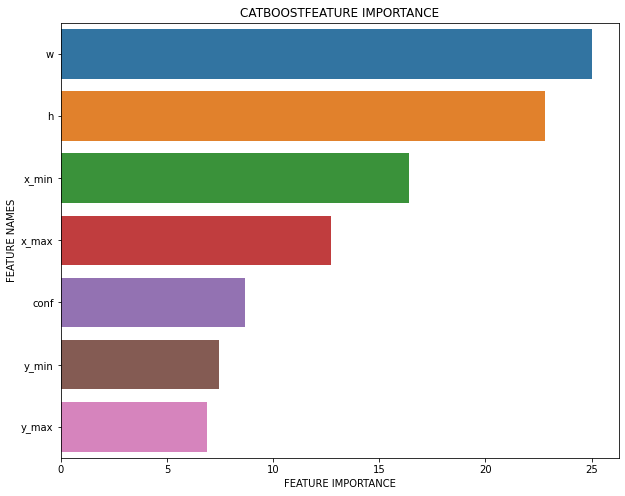

In [13]:
#plot_feature_importance(model_cb.get_feature_importance(), train_df[features].get_feature_names(), 'CATBOOST')
plot_feature_importance(model_cb.get_feature_importance(), features, 'CATBOOST')

In [14]:
preds = model_cb.predict(test_df[['x_min', 'y_min', 'x_max', 'y_max', 'conf', 'h', 'w']])
test_df['distance'] = preds

sample_solution_df = test_df[['image_name', 'distance']]

In [15]:
test_img_names = set(os.listdir(DIR_DATA_TEST))

In [16]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
    lost_test_items.append([file_name, 0])
    
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

sample_solution_df.to_csv(os.path.join(DIR_SUBM, '9_yolo5l_hw_wnulls_cntr.csv'), sep=';', index=False)